The strengths of factorization machines over the linear regression and matrix factorization are: (1) it can model $\chi$-way variable interactions, where $\chi$ is the number of polynomial order and is usually set to two. (2) A fast optimization algorithm associated with factorization machines can reduce the polynomial computation time to linear complexity, making it extremely efficient especially for high dimensional sparse inputs.

### 2-Way Factorization Machines

$\hat{y}(x) = \mathbf{w}_0 + \sum_{i=1}^d \mathbf{w}_i x_i + \sum_{i=1}^d\sum_{j=i+1}^d \langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j$, where $\mathbf{V} \in \mathbb{R}^{d\times k}$, represents feature embeddings.

### An Efficient Optimization Criterion

we can reorganize the third term of FM which could greatly reduce the computation cost, leading to a linear time complexity ($\mathcal{O}(kd)$)

$\begin{split}\begin{aligned}
&\sum_{i=1}^d \sum_{j=i+1}^d \langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j \\
 &= \frac{1}{2} \sum_{i=1}^d \sum_{j=1}^d\langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j - \frac{1}{2}\sum_{i=1}^d \langle\mathbf{v}_i, \mathbf{v}_i\rangle x_i x_i \\
 &= \frac{1}{2} \big (\sum_{i=1}^d \sum_{j=1}^d \sum_{l=1}^k\mathbf{v}_{i, l} \mathbf{v}_{j, l} x_i x_j - \sum_{i=1}^d \sum_{l=1}^k \mathbf{v}_{i, l} \mathbf{v}_{i, l} x_i x_i \big)\\
 &=  \frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i) (\sum_{j=1}^d \mathbf{v}_{j, l}x_j) - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2 \big ) \\
 &= \frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i)^2 - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2)
 \end{aligned}\end{split}$

To learn the FM model, we can use the MSE loss for regression task, the cross-entropy loss for classification tasks, and the BPR loss for ranking task. Standard optimizers such as stochastic gradient descent and Adam are viable for optimization.

In [ ]:
!pip install mxnet-cu101==1.7.0

In [ ]:
!pip install d2l==0.17.5

In [1]:
import os
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

### Model Implementation

In [2]:
class FM(nn.Block):
    def __init__(self, field_dims, num_factors):
        super(FM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Dense(1, use_bias=True)

    def forward(self, x):
        square_of_sum = np.sum(self.embedding(x), axis=1) ** 2
        sum_of_square = np.sum(self.embedding(x) ** 2, axis=1)
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True)
        x = npx.sigmoid(x)
        return x

### Load the Advertising Dataset

In [3]:
batch_size = 2048
data_dir = d2l.download_extract('ctr')
train_data = d2l.CTRDataset(os.path.join(data_dir, 'train.csv'))
test_data = d2l.CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
train_iter = gluon.data.DataLoader(
    train_data, shuffle=True, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(
    test_data, shuffle=False, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())

### Train the Model

loss 0.504, train acc 0.279, test acc 0.273
4966.3 examples/sec on [cpu(0)]


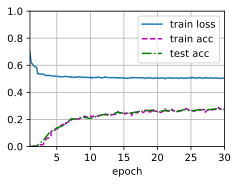

In [4]:
devices = d2l.try_all_gpus()
net = FM(train_data.field_dims, num_factors=20)
net.initialize(init.Xavier(), ctx=devices)
lr, num_epochs, optimizer = 0.02, 30, 'adam'
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {'learning_rate': lr})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)